# **Securing a Win in the Face of Wind Challenges: Onshore Wind Farm Analysis




### Win for the Wind or Perhaps Mind the Wind

The development of offshore wind farms is in 'Deep Water' as supply chain issues, exacerbated by high-interest rates, cast shadows over the returns on offshore renewable projects. Several recent events have exemplified the challenges in this sector:

1) Vattenfall's Exit from Norfolk Boreas Wind Farm Project <br>
* Vattenfall's decision to withdraw from the Norfolk Boreas wind farm project sent ripples through the industry.
([www.theguardian.com](https://www.theguardian.com/business/2023/jul/20/giant-windfarm-norfolk-coast-halted-spiralling-costs-vatttenfall))

2) Renegotiations in PPA Agreement by Equinor and BP
([www.reuters.com](https://www.reuters.com/markets/deals/bp-equinor-revisit-us-offshore-wind-projects-power-sale-agreements-2023-08-01/))
* A joint venture between Equinor and BP renegotiated its Power Purchase Agreement (PPA) in a U.S. offshore wind farm project, reflecting the complexities of project financing.

3) Ørsted's Market Share Plunge
([www.theguardian.com](https://www.theguardian.com/environment/2023/aug/30/orsted-shares-fall-troubles-us-business-wind-power))
* Ørsted, a major player in the offshore wind industry, experienced a sharp 25% drop in its market share price in a single day.

These recent developments, as of September 3, 2023, have left stakeholders in the green transition concerned. In light of these challenges, it might be worthwhile to revisit a more traditional approach: Onshore Wind Farms

## Navigating the Regulatory Landscape of Onshore Wind Farms in the UK

Back in 2015 during the tenure of then Prime Minister David Cameron, the UK government introduced a bill. This legislation granted Local Planning Authorities increased authority to make decisions regarding wind farm projects. Consequently this empowered a residents objection to potentially disrupt an expensive planning application process. <br>

### Project Overview:

In this project, we will conduct an in-depth analysis on renewable energy planning in UK using the [dataset](https://www.gov.uk/government/publications/renewable-energy-planning-database-monthly-extract) sourced from the Department for Energy Security and Net Zero. This datasheet is updated every quarter. <br>


### Challenges and Limitations:

* Data Quality - There are numerous wrong data entries and a substantial volume of empty cells. 
* Model Complexity - Determining the duration required for the application process is challenging due to the varying combinations of project stages that precede operational status.

### Project Objective:
This analysis aims to explore the challenges faced by the wind farm sector providing insights into a promising pathway, for sustainable wind energy development, in the United Kingdom. <br>

**<u>Under the factor of project size and country location<u>** <br>

1) Gain an understanding of trends in onshore wind farm development within the UK. <br>
2) Analyse the time required for processing different size project applications<br> 
3) Investigate historical rates of approval for proposed projects.<br> 
4) Determine typical construction periods, for approved projects.




### Bonus:
* Repeat 1-4 Objective for Commercial Grounded Type Solar Farm.

# Part 1 - **EDA** 
## **Imports and loading**
 * Import the relevant packages and dataset

In [1]:
# Packages for numerics + dataframes
import pandas as pd
import numpy as np

# Packages for visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd

# Packages for reading database
import chardet

with open('repd-july-2023.csv', 'rb') as file:
    raw_data = file.read()
    detected_encoding = chardet.detect(raw_data)['encoding']

df = pd.read_csv('repd-july-2023.csv', encoding=detected_encoding)

## **Analyse**

In this moment, we must consider the following question:
* How to deal with empty entry and wrong data?
* How to deal with outliers and duplicate?
* What data format should we should use? 
* What feature engineering should we carry out? 

In [2]:
# `.shape` and `.info()` are always the best to start with

# Display the dataset's shape
print(df.shape)

# Display basic info about the dataset
df.info()

(9371, 52)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9371 entries, 0 to 9370
Data columns (total 52 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Old Ref ID                               3983 non-null   object 
 1   Ref ID                                   9371 non-null   int64  
 2   Record Last Updated (dd/mm/yyyy)         8667 non-null   object 
 3   Operator (or Applicant)                  9291 non-null   object 
 4   Site Name                                9368 non-null   object 
 5   Technology Type                          9371 non-null   object 
 6   Storage Type                             1247 non-null   object 
 7   Storage Co-location REPD Ref ID          822 non-null    object 
 8   Installed Capacity (MWelec)              8684 non-null   object 
 9   Share Community Scheme                   74 non-null     object 
 10  CHP Enabled                          

### <u>Obtained Information<u>
* It has 9371 rows and 52 columns. It is a massive and complex database.
* Most of the columns are not fully filled - Tricky :3
* Column 8 Installed Capacity indicates numerical power value but in "Object" type data
* Column 37 - 50 records the dates, but in "Object" type data
* All column name are not in "snake_case" format: ie Technology Type -> technology_type

### <u>Empty Value - Why ?<u>
It is because not every single project will go through every section <br>
    
* Let us use the abbreviation below <br>
    
Planning Submitted - S <br> Planning Withdrwan - W <br> Planning Refused - R <br> Planning Granted - G <br>
Appeal Submitted - AS <br>  Appeal Granted - AG <br> Appeal Refused - AR <br>

<br>
i) A highly typical project might be accepted easily. So its steps will be S -> G <br>
ii) Some controversial projects might face hard battle, and get through via appeal. ie S -> R -> AS - AG <br>

> More info can be found here:[link](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/328869/ThePlanningSystemforRenewables-19March2014.pdf)

## **Lets do some data cleaning**
- Remember that those comes in wrong data type, we have to cast them into correct.
- update their name into snake_case format.

In [3]:
# in 'Capacity' column, there are two error: first it contain ' ' and NAN, both will make the conversion fail
# Hence, first we replace ' ' to NAN
df['Installed Capacity (MWelec)'] = df['Installed Capacity (MWelec)'].replace(' ', pd.NA)

# Remember two fundamental column, submission date and capacity are important, we dont wish to have any blank
# Hence, we drop those empty row in 'Installed Capacity (MWelec)' & 'planning_application_submitted'
df = df.dropna(subset=['Planning Application Submitted','Installed Capacity (MWelec)'])

# Tips from previous trial: Create a copy, so that a revert is possible down the line
# Hence, I create a new dataframe.
df_rough = pd.DataFrame()

# Import those important information into new dataframe, and:
# i) update the name format into snake_case
# ii) convert them into the right datatype

df_rough['id'] = df['Ref ID']
df_rough['technology'] = df['Technology Type']
df_rough['capacity'] = df['Installed Capacity (MWelec)'].astype(float)
df_rough['solar_type'] = df['Mounting Type for Solar']
df_rough['country'] = df['Country']
df_rough['region'] = df['Region']

# Use to_datetime function to change the object type date column into respective datetime type
# Note: in 20/8/2014 = 20th Aug 2014. so date is at the firstplace
# Hence, I input the argument dayfirst=True
# Also, data conversion cant handle empty value, use errors='coerce'. Those empty value cell will become NaT

df_rough['planning_application_submitted'] = pd.to_datetime(df['Planning Application Submitted'], dayfirst=True, errors='coerce')
df_rough['planning_application_withdrawn'] = pd.to_datetime(df['Planning Application Withdrawn'], dayfirst=True, errors='coerce')
df_rough['planning_permission_refused'] = pd.to_datetime(df['Planning Permission Refused'], dayfirst=True, errors='coerce')
df_rough['planning_permission_granted'] = pd.to_datetime(df['Planning Permission Granted'], dayfirst=True, errors='coerce')
df_rough['under_construction'] = pd.to_datetime(df['Under Construction'], dayfirst=True, errors='coerce')
df_rough['operational'] = pd.to_datetime(df['Operational'], dayfirst=True, errors='coerce')

- Validate your new dataframe


In [4]:
df_rough.head()

,id,technology,capacity,solar_type,country,region,planning_application_submitted,planning_application_withdrawn,planning_permission_refused,planning_permission_granted,under_construction,operational
0,1,Biomass (co-firing),35.0,NaN,Wales,Wales,2004-04-16,NaT,NaT,2004-09-03,2006-05-01,2007-05-01
1,2,Biomass (co-firing),170.0,NaN,Scotland,Scotland,2010-06-02,2012-06-27,NaT,NaT,NaT,NaT
2,3,EfW Incineration,70.0,NaN,England,Yorkshire and Humber,2014-08-20,NaT,NaT,2015-10-28,2016-09-01,2019-12-20
3,4,Biomass (dedicated),38.5,NaN,England,Eastern,1994-06-23,NaT,NaT,1995-05-05,NaT,1998-10-02
4,5,Biomass (dedicated),8.8,NaN,England,East Midlands,1997-06-24,NaT,1999-02-01,NaT,NaT,NaT


* Although it looks okay, there are still some hidden errors burried deep in this dataframe

# Part 2 
## **Objective No 1**
Gain an understanding of trends in onshore wind farm and grounded type solar farm development within the UK. <br>
- I decided to show solar side by side with onshore wind farm for simplicity purpose.  
- For this objective only, I removed data entry for project submitted before 2000 as it is insignificant.

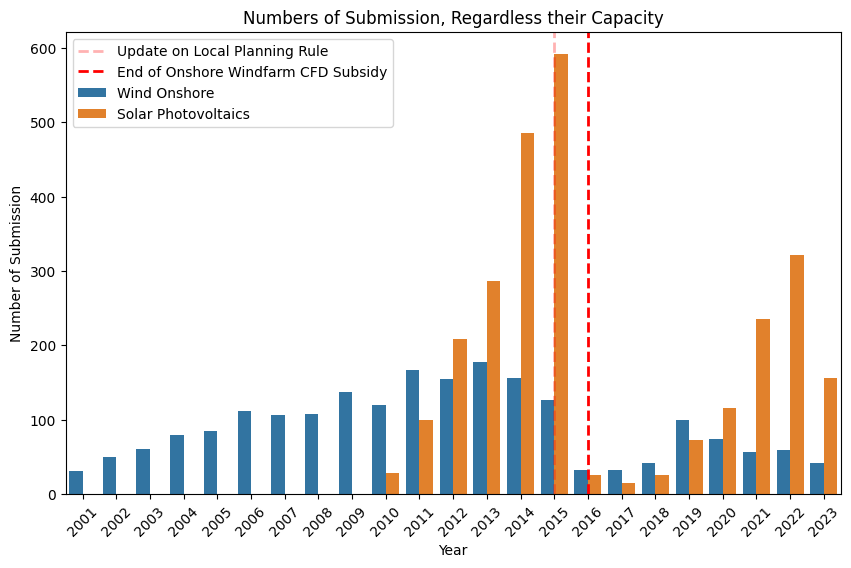

In [5]:
# Filter the dataframe for Onshore wind farm & Ground type solar farm
df_q1= df_rough[((df_rough['technology'] == 'Solar Photovoltaics') & (df_rough['solar_type'] == 'Ground')) 
               | (df_rough['technology'] == 'Wind Onshore')].copy()

# Create a new column to extract the year value
df_q1['year'] = df_q1['planning_application_submitted'].dt.year.astype(int)

# Count each submission entry at particular year based on either onshore wind or solar
group_q1 = df_q1.groupby(['year','technology']).size()

# Convert the tabulated group data into a new dataframe for plotting purpose
df_q1_group = pd.DataFrame(group_q1.to_frame(name = 'count').reset_index())

# Filter the insignificant entry, by setting a cutoff beginning year 2000
df_q1_group = df_q1_group[df_q1_group['year'] > 2000].reset_index(drop=True)

# Data Visualisation
plt.figure(figsize=(10,6))
sns.barplot(data=df_q1_group, x='year', y='count', hue='technology')
plt.title('Numbers of Submission, Regardless their Capacity')
plt.xlabel('Year')
plt.ylabel('Number of Submission')
plt.xticks(rotation=45)
plt.axvline(x=14, color='red', linestyle='--', alpha=0.3, linewidth=2, label='Update on Local Planning Rule')
plt.axvline(x=15, color='red', linestyle='--', linewidth=2, label='End of Onshore Windfarm CFD Subsidy')
plt.legend(loc='upper left')
plt.show()

### <u>Information from the visualisation<u>
i) At first, we can notice since 2000, there is an upward trend for submission until 2011. <br>
ii) That trend become a flat stagnation until the announcement of new planning rule. <br>
iii) Both type of renewable development suffered heabily from the changes in planning rule.

## **Objective No 2**

Under the factor of project size and country location, analyse the time required for processing project applications within this industry. <br> 
- This brings us to a question. How do you define process time? <br> 
- I define as the application process when get first approval or rejection, while not considering appealing or reapply etc. 


In [6]:
# Lets solely focus on Onshore Wind only
df_wind = df_rough[df_rough['technology'] == 'Wind Onshore'].copy()

# Submitted proposal that was withdrawn voluntarily by the applicants is not helpful.
# To determine the processing speed, only data with 'Empty' Withdrawn will be analysed.
df_wind = df_wind[pd.isna(df_wind['planning_application_withdrawn'])]

# Create a new filter criteria to select the column you need
wind_column_data=['id', 'capacity', 'country', 'planning_application_submitted',
             'planning_permission_refused', 'planning_permission_granted']                   
df_wind = df_wind[wind_column_data]

# Reset the Index
df_wind =df_wind.reset_index(drop=True)

# We have too many alternative scenario to cover in process time.
# A function is created to calculate and sort out the fastest respond 
def process_len(df_ori):    
    df_ori['refused'] = df_ori['planning_permission_refused'] - df_ori['planning_application_submitted']
    df_ori['granted'] = df_ori['planning_permission_granted'] - df_ori['planning_application_submitted']
    
    # Row with "NaT" in "timedelta64" data type has to be filled with 0 before data type conversion
    df_ori['refused'].fillna(pd.Timedelta(days=0), inplace=True)
    df_ori['granted'].fillna(pd.Timedelta(days=0), inplace=True)
    
    # Convert them into int
    df_ori['refused'] = df_ori['refused'].dt.days.astype(int)
    df_ori['granted'] = df_ori['granted'].dt.days.astype(int)
    
    df_ori['process_time'] = df_ori.apply(lambda row: 
                                  min(row['refused'], row['granted']) if row['refused'] != 0 and row['granted'] != 0 
                                  else row['refused'] if row['granted'] == 0 
                                  else row['granted'] if row['refused'] == 0
                                  else 0, axis=1)
    #there will be 4 scenario from this data:
    # i) it was rejected, but granted followed by appealing. 
    # We choose the min between "refused" and "granted" process. as we would like to know the first reaction time from the authority
    
    # ii) it was rejected, with no appealing
    # We choose the refused time when there is granted time is 0
    
    # iii) it was granted, didnt go through the rejection process
    # We choose the granted time when there is refused time is 0

    # iv) still waiting for decision
    # Ignore and set them as 0, make sure this is isolated before calculating the average time.
    return df_ori

df_wind = process_len(df_wind)
df_wind.head(2)

,id,capacity,country,planning_application_submitted,planning_permission_refused,planning_permission_granted,refused,granted,process_time
0,2549,1.5,England,1998-03-09,2001-05-02,NaT,1150,0,1150
1,2550,1.5,England,1998-03-09,2001-05-02,NaT,1150,0,1150


- Examine df_wind result

In [7]:
df_exam = df_wind[(df_wind['refused']>df_wind['granted']) & (df_wind['granted']!= 0)]
df_exam.head(20)

# If we look at this particular result, it will looks a bit strange?
# Why? How can you gained the permission, before your application get rejected, it makes no sense to me

# If you cross checked the ID, all project are in operational state, except ID: 2710.
# This project reapplied a new ref ID, revising the project.

# Those must be a wrong value key into the 'Planning Permission Refused' Column
# However, since our process_len function choose the min between two values, we can ignore this issue.


,id,capacity,country,planning_application_submitted,planning_permission_refused,planning_permission_granted,refused,granted,process_time
75,2691,2.3,Scotland,2008-08-05,2016-05-16,2009-08-14,2841,374,374
78,2694,1.5,England,2009-06-05,2017-02-02,2009-09-11,2799,98,98
79,2695,2.0,England,2009-08-04,2018-04-27,2012-10-17,3188,1170,1170
80,2697,4.3,Scotland,2008-03-11,2013-04-11,2009-01-06,1857,301,301
86,2704,1.5,Scotland,2009-02-13,2019-05-24,2009-12-22,3752,312,312
90,2708,2.3,Scotland,2008-11-15,2016-07-19,2009-10-16,2803,335,335
91,2710,20.7,Northern Ireland,2009-01-10,2015-01-12,2010-12-13,2193,702,702
92,2711,13.2,Scotland,1996-02-10,2019-05-24,1998-10-12,8504,975,975
1146,4271,8.0,England,2013-06-28,2015-09-24,2014-02-06,818,223,223


- Lets examine whether we have a negative process time value

In [8]:
print(df_wind[df_wind['process_time'] < 0]['process_time'].count())
# This must be a wrong entry in the planning_application_submitted. 

1


In [9]:
# Remove negative process time
criteria = df_wind['process_time'] < 0
df_wind.drop(df_wind[criteria].index, inplace=True)

# Tidy it up by dropping submitted,refused and granted.
df_wind_clean = df_wind.drop(columns = ['planning_application_submitted', 'planning_permission_refused',
                                    'planning_permission_granted']
                         ,axis=1).copy()

# Reset the Index
df_wind_clean.reset_index(drop=True)

,id,capacity,country,refused,granted,process_time
0,2549,1.50,England,1150,0,1150
1,2550,1.50,England,1150,0,1150
2,2554,1.50,England,0,343,343
3,2555,1.50,England,343,0,343
4,2556,1.50,England,0,354,354
...,...,...,...,...,...,...
1992,14131,0.25,Northern Ireland,0,0,0
1993,14132,2.00,Northern Ireland,0,0,0
1994,14143,30.00,Northern Ireland,0,230,230
1995,14255,1.00,Scotland,0,0,0


## **Additional Information**
> Based on Planning System for Renewable 2014 :[link](https://www.aberdeenshire.gov.uk/media/11384/section5windturbinesinthestudyareaaslcassessmentmarch2014.pdf) <br>

**I categorise the capacity size into small, medium and large**<br>
i) < 20MW = small<br>
ii) in between 20 and 50MW = medium<br>
iii) > 50MW = large<br>



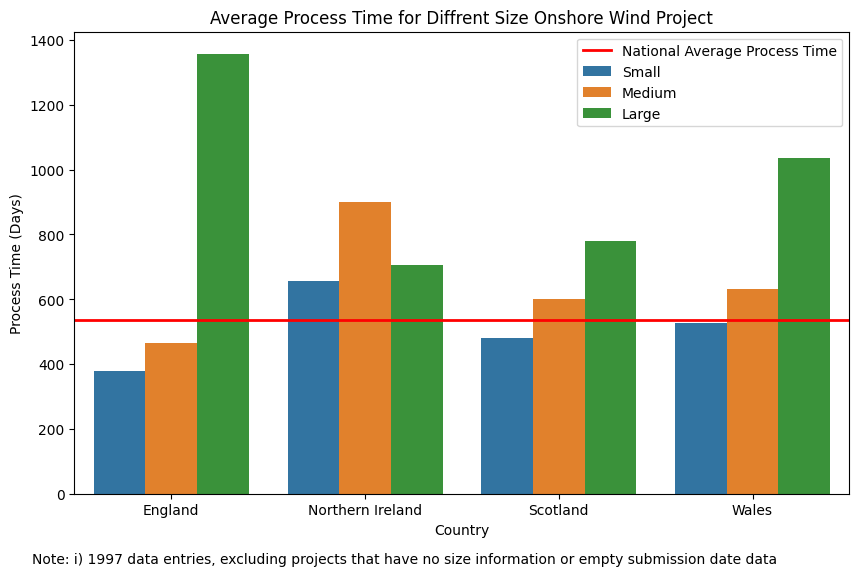

In [10]:
# Define the edge of each backet
wind_size_edge = [0, 20, 50, float('inf')]
# Create size label
wind_size_label = ['Small', 'Medium', 'Large']
# Create a new column and categorise as above
df_wind_clean['size'] = pd.cut(df_wind_clean['capacity'], 
                       bins=wind_size_edge, 
                       labels=wind_size_label)


# Grouping the data based on country and size and save them into a new dataframe
avg_wind_process_country = df_wind_clean.groupby(by=['country','size'])['process_time'].mean()
df_q1_group_process_wind = pd.DataFrame(avg_wind_process_country.to_frame(name = 'process_time').reset_index())

# Data Visualisation
plt.figure(figsize=(10,6))
sns.barplot(data=df_q1_group_process_wind, x='country', y='process_time', hue='size')
plt.title('Average Process Time for Diffrent Size Onshore Wind Project')
plt.xlabel('Country')
plt.ylabel('Process Time (Days)')
plt.xticks(rotation=0, ha='center')
plt.axhline(y=df_wind_clean['process_time'].mean(), color='red', 
            linewidth=2, label='National Average Process Time')
plt.legend(loc='upper right')
plt.annotate("Note:" + " i) " + str(len(df_wind_clean)) + " data entries, excluding projects that have no size information or empty submission date data", 
             (0, 0), xycoords='data', textcoords='offset points', 
             xytext=(-100, -50), ha='left')
plt.show()

### <u>Information from the visualisation<u>
i) As project size (capacity) increases, the expected outcome is a corresponding increase in process length.<br>

ii) With the exception of Northern Ireland, all countries exhibit a consistent trend. In Northern Ireland, the average process time for Medium-sized projects surpasses that of Large-sized projects. This anomaly warrants further investigation. <br>

iii) In England and Wales, Large-sized projects experience the long processing times, which are two times the national average. <br>

## **Objective No 3**

Under the factor of project size and country location, investigate historical rates of approval for proposed projects.<br> 

* Total Number of Granted Project / Total Submission
* Then we further break them down into Size and Country Location

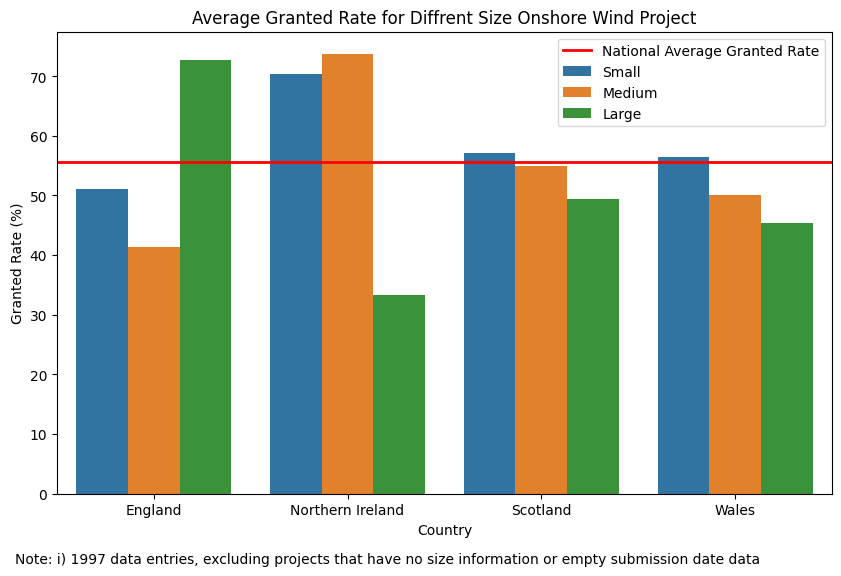

In [11]:
# Use len function to calculate the number of granted project over total submission
# Round it off to 3 significant figure

# Compute the national average
avg_wind_granted_national = round(len(df_wind_clean[df_wind_clean['granted']>0]) / 
                              len(df_wind_clean),3) * 100

# Compute the national average based on Size and Country
avg_wind_granted_country = (df_wind_clean[df_wind_clean['granted'] != 0].groupby(by=['country','size'])['capacity'].count() / 
                        df_wind_clean.groupby(by=['country','size'])['capacity'].count()) * 100

# Save them into a dataframe for visualisation purpose
df_q1_group_granted = pd.DataFrame(avg_wind_granted_country.to_frame(name = 'granted_percentage').reset_index())

# Data visualisation
plt.figure(figsize=(10,6))
sns.barplot(data=df_q1_group_granted, x='country', y='granted_percentage', hue='size')
plt.title('Average Granted Rate for Diffrent Size Onshore Wind Project')
plt.xlabel('Country')
plt.ylabel('Granted Rate (%)')
plt.xticks(rotation=0, ha='center')
plt.axhline(y=avg_wind_granted_national, color='red', 
            linewidth=2, label='National Average Granted Rate')
plt.legend(loc='upper right')
plt.annotate("Note:" + " i) " + str(len(df_wind_clean)) + " data entries, excluding projects that have no size information or empty submission date data", 
             (0, 0), xycoords='data', textcoords='offset points', 
             xytext=(-100, -50), ha='left')
plt.show()


### <u>Information from the visualisation<u>
i) As project size (capacity) increase, we do expected that the granted rate fall due to complexity. <br>
ii) However, only England don't follow the trends where there is a spike in approval rate for large size project<br>
iii) Scotland & Wales are roughly below the national approval rate.

* lets dive deeper into the number submission per size per country location

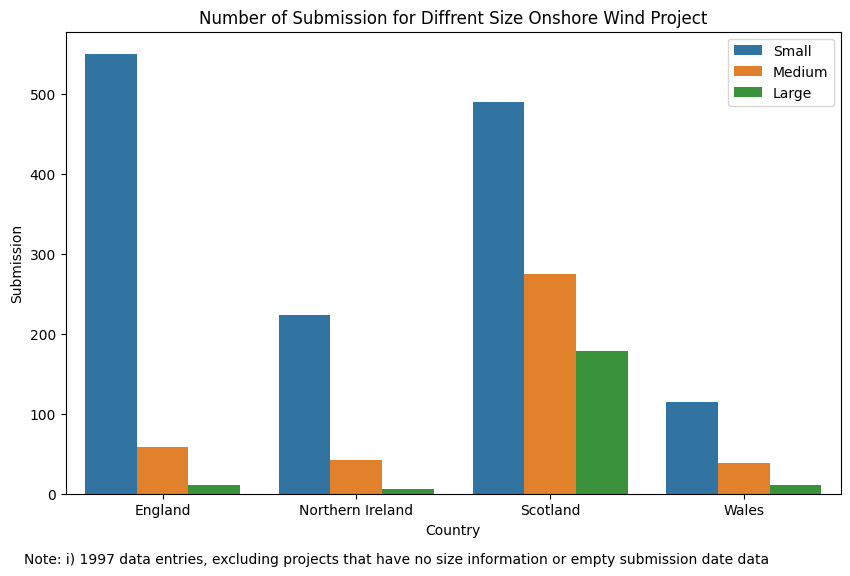

In [12]:
# Count the number of submission per size per country location
number_of_submission = df_wind_clean.groupby(by=['country','size'])['capacity'].count()

# Save them into a dataframe for visualisation purpose
df_q1_number = pd.DataFrame(number_of_submission.to_frame(name = 'number_submission').reset_index())

# Data Visualisation
plt.figure(figsize=(10,6))
sns.barplot(data=df_q1_number, x='country', y='number_submission', hue='size')
plt.title('Number of Submission for Diffrent Size Onshore Wind Project')
plt.xlabel('Country')
plt.ylabel('Submission')
plt.xticks(rotation=0, ha='center')
plt.legend(loc='upper right')
plt.annotate("Note:" + " i) " + str(len(df_wind_clean)) + " data entries, excluding projects that have no size information or empty submission date data", 
             (0, 0), xycoords='data', textcoords='offset points', 
             xytext=(-100, -50), ha='left')
plt.show()


### <u>Information from the visualisation<u>
i) Scotland has the height submission for large size onshore wind farm project, suggesting that investors & project developers favour and confident in investing in Scotland. <br>
ii) Project developers in all region beside Scotland are more cautious in proceeding with large size project <br>

* Lets indicate the number of project which pass or fail 

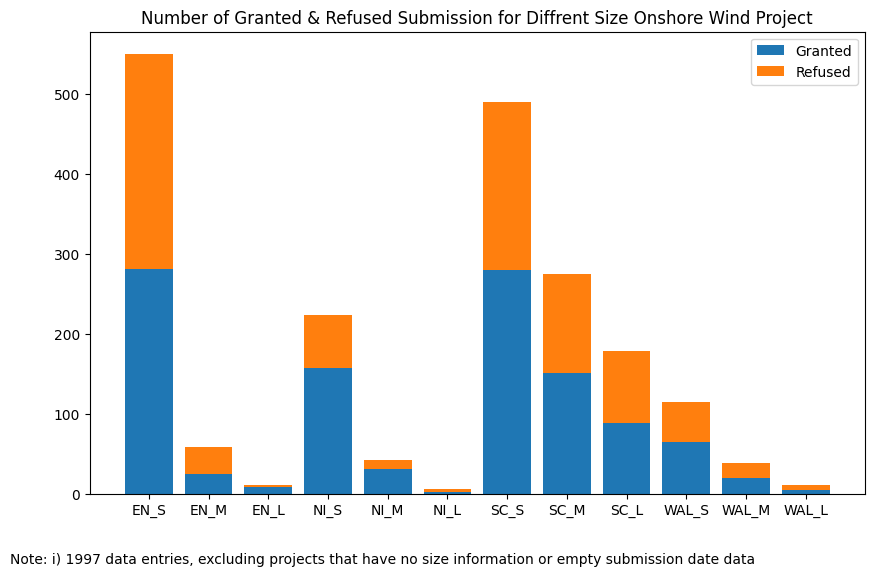

In [13]:
# Copy a set of calculated dataframe into new 
df_q1_number_break_down = df_q1_number.copy()

# Copy the approval rate into the new data
df_q1_number_break_down['granted_percentage'] = df_q1_group_granted['granted_percentage']

# Manually categorise them into 2: by multiplying the total amount with approval rate
df_q1_number_break_down['granted'] = df_q1_number_break_down['number_submission'] * df_q1_number_break_down['granted_percentage']/100
df_q1_number_break_down['refused'] = df_q1_number_break_down['number_submission'] - df_q1_number_break_down['granted']

# Create a dictionary to map the country names to abbreviations
country_abbreviations = {"England": "EN", "Northern Ireland": "NI", "Scotland": "SC", "Wales": "WAL"}

# Create a new column called "country_abbreviation" that contains the abbreviation of country
df_q1_number_break_down["country_abbreviation"] = df_q1_number_break_down["country"].map(country_abbreviations)

# Create a dictionary to map the size to abbreviations
size_abbreviations = {"Small": "S", "Medium": "M", "Large": "L"}

# Create a new column called "size_abbreviation" that contains the abbreviation of size
df_q1_number_break_down["size_abbreviations"] = df_q1_number_break_down["size"].astype('object').map(size_abbreviations)

# Combine both together.
# For example: EN_L symbolise england-large, etc
df_q1_number_break_down["country_size"] = ( df_q1_number_break_down["country_abbreviation"] + "_" + 
                                            df_q1_number_break_down["size_abbreviations"] )

# Data Visualisation
plt.figure(figsize=(10, 6))
plt.bar(df_q1_number_break_down["country_size"], df_q1_number_break_down["granted"], label="Granted")
plt.bar(df_q1_number_break_down["country_size"], df_q1_number_break_down["refused"], bottom=df_q1_number_break_down["granted"], label="Refused")
plt.title('Number of Granted & Refused Submission for Diffrent Size Onshore Wind Project')
plt.xticks(rotation=0, ha='center')
plt.annotate("Note:" + " i) " + str(len(df_wind_clean)) + " data entries, excluding projects that have no size information or empty submission date data", 
             (0, 0), xycoords='data', textcoords='offset points', 
             xytext=(-100, -50), ha='left')
plt.legend()

### <u>Information from the visualisation<u>
* This visualisation answers the reason why large onshore wind farm projects in England has high approval rate. It is all due by low submission volumes. <br>
* The observation suggests that investors tend to prioritize quality over quantity when submitting applications, focusing on those with a higher probability of success. This behavior can be linked to the considerable opposition from the local community, often vocalised through the "Not in my backyard" sentiment.

## **Objective No 4**

* Determine typical construction periods, for approved projects

In [14]:
# Create a new dataframe with focusing on onshore wind
df_wind_construct = df_rough[df_rough['technology'] == 'Wind Onshore']

# Extract the desired column data
column_data_construct=['capacity', 'country', 'operational', 'under_construction']                   
df_wind_construct = df_wind_construct[column_data_construct]

# Exclude projects that has no start time or operational time
df_wind_construct = df_wind_construct.dropna(subset=('under_construction', 'operational'))

# Construction time is calculated based with Operational start time - Construction start time
df_wind_construct['construct_time'] = df_wind_construct['operational'] - df_wind_construct['under_construction']
df_wind_construct['construct_time'] = df_wind_construct['construct_time'].dt.days.astype(int)

# Ref to Objective 2 for categorising the size
df_wind_construct['size'] = pd.cut(df_wind_construct['capacity'], 
                       bins=wind_size_edge, 
                       labels=wind_size_label)

- Lets examine whether we have a negative construction time value

In [15]:
print(df_wind_construct[df_wind_construct['construct_time'] < 0]['construct_time'].count())
# This must be a wrong data entry 

2


In [16]:
# Remove negative Construction time
criteria_construct = df_wind_construct['construct_time'] < 0
df_wind_construct.drop(df_wind_construct[criteria_construct].index, inplace=True)

# Reset the Index
df_wind_construct.reset_index(drop=True)

,capacity,country,operational,under_construction,construct_time,size
0,10.4,England,2007-08-07,2007-04-01,128,Small
1,2.4,Scotland,2013-02-18,2012-02-28,356,Small
2,20.0,Scotland,2011-09-01,2010-12-01,274,Small
3,26.0,Wales,2011-04-14,2010-07-01,287,Medium
4,2.0,England,2011-08-12,2010-01-01,588,Small
...,...,...,...,...,...,...
524,1.5,Scotland,2015-01-01,2014-12-01,31,Small
525,2.5,Wales,2022-02-01,2021-10-01,123,Small
526,2.6,Scotland,2003-07-01,2003-01-01,181,Small
527,1.9,England,2021-09-01,2020-12-02,273,Small


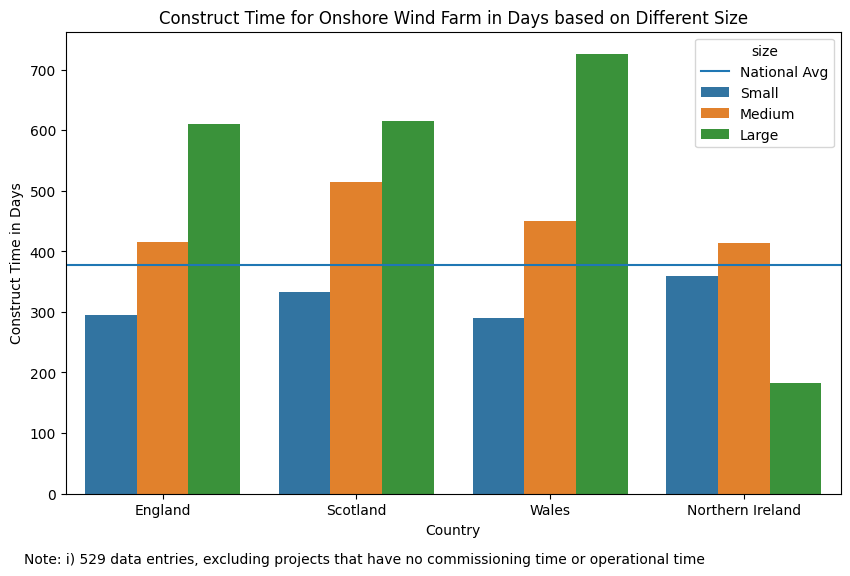

In [17]:
# Data Visualisation
plt.figure(figsize=(10,6))
sns.barplot(data=df_wind_construct, x='country', y='construct_time', hue='size', errorbar=None)
plt.axhline(y=df_wind_construct['construct_time'].mean(), label='National Avg')
plt.xlabel('Country')
plt.ylabel('Construct Time in Days')
plt.title('Construct Time for Onshore Wind Farm in Days based on Different Size')
plt.annotate("Note:" + " i) " + str(len(df_wind_construct)) + " data entries, excluding projects that have no commissioning time or operational time ", 
             (0, 0), xycoords='data', textcoords='offset points', 
             xytext=(-100, -50), ha='left')

plt.legend(title='size')
plt.show()

### <u>Information from the visualisation<u>
* This visualization indicates that the construction period remains relatively consistent across various project sizes and regions, except for large onshore wind farm in North Ireland.
* The exception in North Ireland is primarily attributed to insufficient data (only one data entry), preventing a meaningful average calculation.

# **<u>Conclusion - Onshore Wind<u>**

* A limited number of submissions are observed for Large-sized projects in England and Wales. This scenario may be attributed to the prolonged processing times experienced by Large-sized projects in these regions, which are twice the national average. The extended processing duration might due to a robust opposition from the local communities in both countries. Consequently, project developers found themselves investing more time in engaging with a broader range of stakeholders. <br>
<br>

* Scotland continues to hold its position as the premier destination for onshore windfarm projects, accumulating the highest total number of submissions and maintaining an impressive approval rate exceeding 50% for each size category. <br>
<br>

* The construction period remains remarkably consistent across different project sizes, indicating that geographical factors have minimal impact. <br>

# **Bonus - Grounded type Solar Farm**

* This section will follow  the methodology in analysing the onshore windfarm data

## **Objective No 2 - Solar (Process Application Duration)**

In [18]:
# Lets solely focus on Grounded type Solar Farm only
df_solar = df_rough[(df_rough['technology'] == 'Solar Photovoltaics') & (df_rough['solar_type'] == 'Ground')]

# Submitted proposal that was withdrawn voluntarily by the applicants is not helpful.
# To determine the processing speed, only data with 'Empty' Withdrawn will be analysed.
df_solar = df_solar[pd.isna(df_solar['planning_application_withdrawn'])]

# Create a new filter criteria to select the column you need
column_data=['capacity', 'country', 'planning_application_submitted',
             'planning_permission_refused', 'planning_permission_granted']                   
df_solar = df_solar[column_data]

# Reset the Index
df_solar =df_solar.reset_index(drop=True)

#process_len function is defined above
df_solar = process_len(df_solar)

- Examine df_solar result

In [19]:
df_exam = df_solar[(df_solar['refused']>df_solar['granted']) & (df_solar['granted']!= 0)]
df_exam.head(5)

# We have no unexpected result-. 

,capacity,country,planning_application_submitted,planning_permission_refused,planning_permission_granted,refused,granted,process_time


- Lets examine whether we have a negative process time value

In [20]:
print(df_solar[df_solar['process_time'] < 0]['process_time'].count())
# No unexpected result, process_time always positive. Move on

0


## **Additional Information**

> No comprehensive guideline can be found, as each country employs its unique approach to interpreting project size. Perhaps you can suggest for me !

* I categorise the capacity size into small, medium and large. <br>
i) < 1 MW = small<br>
ii) in between 1 and 10MW = medium<br>
iii) > 10MW = large<br>

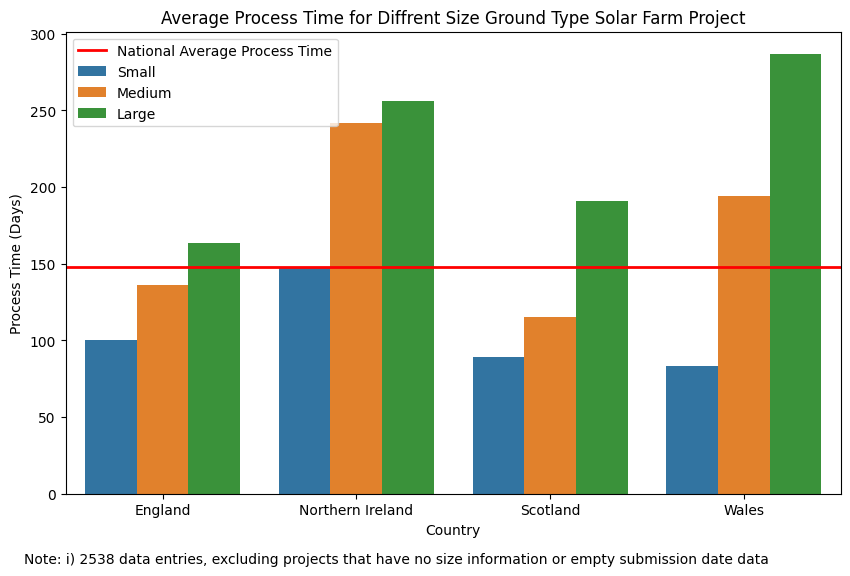

In [21]:
df_solar_clean = df_solar.drop(columns = ['planning_application_submitted', 'planning_permission_refused',
                                    'planning_permission_granted']
                         ,axis=1)
# remove unwanted column
df_solar_clean.reset_index(drop=True)

# Define the edge of each backet
solar_size_edge = [0, 1, 10, float('inf')]
# Create size label
solar_size_label = ['Small', 'Medium', 'Large']
# Create a new column and categorise as above
df_solar_clean['size'] = pd.cut(df_solar_clean['capacity'], 
                       bins=solar_size_edge, 
                       labels=solar_size_label)

# Grouping the data based on country and size and save them into a new dataframe
avg_solar_process_country = df_solar_clean.groupby(by=['country','size'])['process_time'].mean()
df_q1_group_process_solar = pd.DataFrame(avg_solar_process_country.to_frame(name = 'process_time').reset_index())

# Data Visualisation
plt.figure(figsize=(10,6))
sns.barplot(data=df_q1_group_process_solar, x='country', y='process_time', hue='size')
plt.title('Average Process Time for Diffrent Size Ground Type Solar Farm Project')
plt.xlabel('Country')
plt.ylabel('Process Time (Days)')
plt.xticks(rotation=0, ha='center')
plt.axhline(y=df_solar_clean['process_time'].mean(), color='red', 
            linewidth=2, label='National Average Process Time')
plt.legend(loc='upper left')
plt.annotate("Note:" + " i) " + str(len(df_solar_clean)) + " data entries, excluding projects that have no size information or empty submission date data", 
            (0, 0), xycoords='data', textcoords='offset points',
            xytext=(-100, -50), ha='left')
plt.show()

## **Objective No 3 - Solar (Approval Rate)**

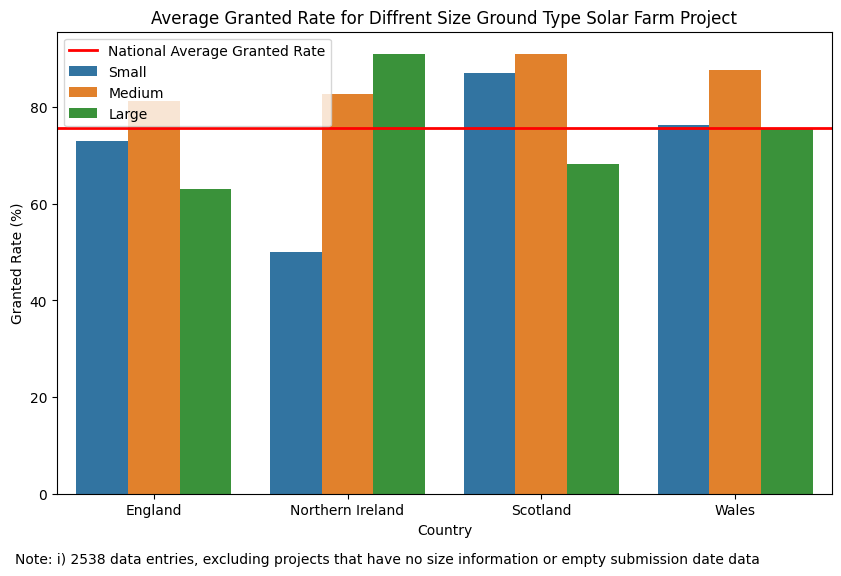

In [22]:
# Use len function to calculate the number of granted project over total submission
# Round it off to 3 significant figure

# Compute the national average
avg_solar_granted_national = round(len(df_solar_clean[df_solar_clean['granted']>0]) / 
                              len(df_solar_clean),3) * 100

# Compute the national average based on Size and Country
avg_solar_granted_country = (df_solar_clean[df_solar_clean['granted'] != 0].groupby(by=['country','size'])['capacity'].count() / 
                        df_solar_clean.groupby(by=['country','size'])['capacity'].count()) * 100

# Save them into a dataframe for visualisation purpose
df_q1_group_granted_solar = pd.DataFrame(avg_solar_granted_country.to_frame(name = 'granted_percentage').reset_index())

# Data visualisation
plt.figure(figsize=(10,6))
sns.barplot(data=df_q1_group_granted_solar, x='country', y='granted_percentage', hue='size')
plt.title('Average Granted Rate for Diffrent Size Ground Type Solar Farm Project')
plt.xlabel('Country')
plt.ylabel('Granted Rate (%)')
plt.xticks(rotation=0, ha='center')
plt.axhline(y=avg_solar_granted_national, color='red', 
            linewidth=2, label='National Average Granted Rate')
plt.legend(loc='upper left')
plt.annotate("Note:" + " i) " + str(len(df_solar_clean)) + " data entries, excluding projects that have no size information or empty submission date data", 
             (0, 0), xycoords='data', textcoords='offset points', 
             xytext=(-100, -50), ha='left')
plt.show()

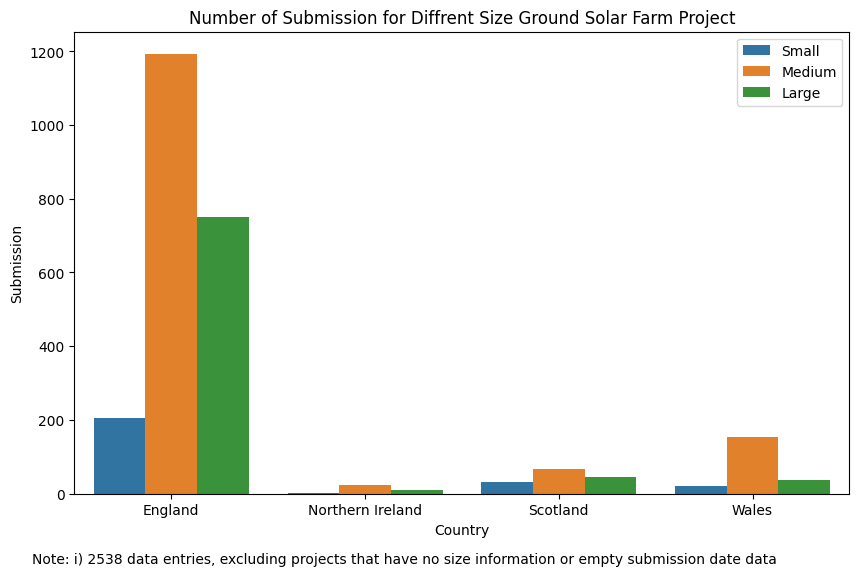

In [23]:
# Count the number of submission per size per country location
number_of_submission_solar = df_solar_clean.groupby(by=['country','size'])['capacity'].count()

# Save them into a dataframe for visualisation purpose
df_q1_number_solar = pd.DataFrame(number_of_submission_solar.to_frame(name = 'number_submission').reset_index())

# Data Visualisation
plt.figure(figsize=(10,6))
sns.barplot(data=df_q1_number_solar, x='country', y='number_submission', hue='size')
plt.title('Number of Submission for Diffrent Size Ground Solar Farm Project')
plt.xlabel('Country')
plt.ylabel('Submission')
plt.xticks(rotation=0, ha='center')
plt.legend(loc='upper right')
plt.annotate("Note:" + " i) " + str(len(df_solar_clean)) + " data entries, excluding projects that have no size information or empty submission date data", 
             (0, 0), xycoords='data', textcoords='offset points', 
             xytext=(-100, -50), ha='left')
plt.show()

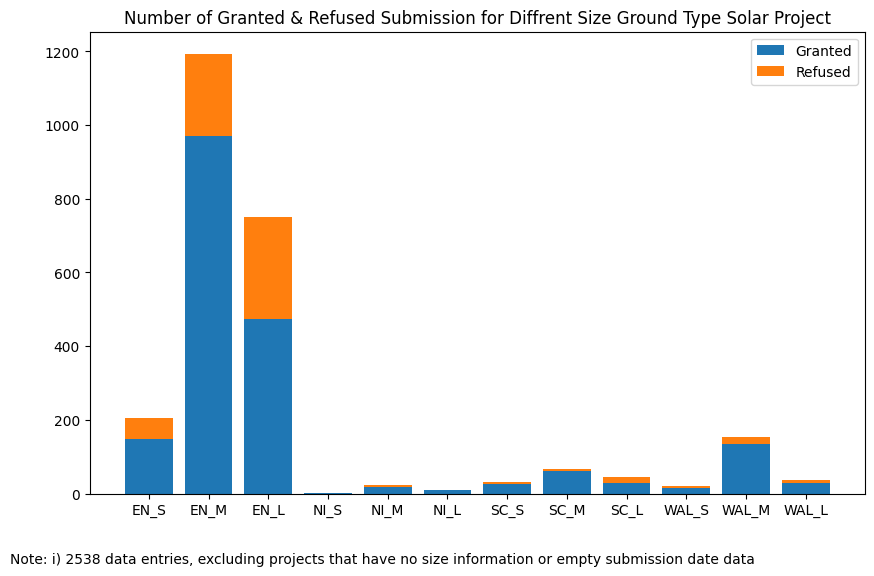

In [24]:
# Copy a set of calculated dataframe into new 
df_q1_number_break_down_solar = df_q1_number_solar.copy()

# Copy the approval rate into the new data
df_q1_number_break_down_solar['granted_percentage'] = df_q1_group_granted_solar['granted_percentage']

# Manually categorise them into 2: by multiplying the total amount with approval rate
df_q1_number_break_down_solar['granted'] = df_q1_number_break_down_solar['number_submission'] * df_q1_number_break_down_solar['granted_percentage']/100
df_q1_number_break_down_solar['refused'] = df_q1_number_break_down_solar['number_submission'] - df_q1_number_break_down_solar['granted']

# Create a dictionary to map the country names to abbreviations
country_abbreviations = {"England": "EN", "Northern Ireland": "NI", "Scotland": "SC", "Wales": "WAL"}

# Create a new column called "country_abbreviation" that contains the abbreviation of country
df_q1_number_break_down_solar["country_abbreviation"] = df_q1_number_break_down_solar["country"].map(country_abbreviations)

# Create a dictionary to map the size to abbreviations
size_abbreviations = {"Small": "S", "Medium": "M", "Large": "L"}

# Create a new column called "size_abbreviation" that contains the abbreviation of size
df_q1_number_break_down_solar["size_abbreviations"] = df_q1_number_break_down_solar["size"].astype('object').map(size_abbreviations)

# Combine both together.
# For example: EN_L symbolise england-large, etc
df_q1_number_break_down_solar["country_size"] = ( df_q1_number_break_down_solar["country_abbreviation"] + "_" + 
                                            df_q1_number_break_down_solar["size_abbreviations"] )

# Data Visualisation
plt.figure(figsize=(10, 6))
plt.bar(df_q1_number_break_down_solar["country_size"], df_q1_number_break_down_solar["granted"], label="Granted")
plt.bar(df_q1_number_break_down_solar["country_size"], df_q1_number_break_down_solar["refused"], bottom=df_q1_number_break_down_solar["granted"], label="Refused")
plt.title('Number of Granted & Refused Submission for Diffrent Size Ground Type Solar Project')
plt.xticks(rotation=0, ha='center')
plt.annotate("Note:" + " i) " + str(len(df_solar_clean)) + " data entries, excluding projects that have no size information or empty submission date data", 
             (0, 0), xycoords='data', textcoords='offset points', 
             xytext=(-100, -50), ha='left')
plt.legend()

## **Objective No 4 - Solar (Construction Time)**

In [25]:
# Create a new dataframe with focusing on Ground Type Solar
df_solar_construct = df_rough[(df_rough['technology'] == 'Solar Photovoltaics') & (df_rough['solar_type'] == 'Ground')]

# Extract the desired column data
column_data_construct=['capacity', 'country', 'operational', 'under_construction']                   
df_solar_construct = df_solar_construct[column_data_construct]

# Exclude projects that has no start time or operational time
df_solar_construct = df_solar_construct.dropna(subset=('under_construction', 'operational'))

# Construction time is calculated based with Operational start time - Construction start time
df_solar_construct['construct_time'] = df_solar_construct['operational'] - df_solar_construct['under_construction']
df_solar_construct['construct_time'] = df_solar_construct['construct_time'].dt.days.astype(int)

# Ref to above for categorising the size
df_solar_construct['size'] = pd.cut(df_solar_construct['capacity'], 
                       bins=solar_size_edge, 
                       labels=solar_size_label)

- Lets examine whether we have a negative construction time value

In [26]:
print(df_solar_construct[df_solar_construct['construct_time'] < 0]['construct_time'].count())

17


In [27]:
# Remove negative Construction time
criteria_construct = df_solar_construct['construct_time'] < 0
df_solar_construct.drop(df_solar_construct[criteria_construct].index, inplace=True)

# Reset the Index
df_solar_construct.reset_index(drop=True)

,capacity,country,operational,under_construction,construct_time,size
0,5.00,England,2013-02-28,2012-06-01,272,Medium
1,1.30,England,2012-09-01,2012-04-01,153,Medium
2,2.00,England,2011-09-01,2011-08-01,31,Medium
3,4.60,England,2011-10-01,2011-08-01,61,Medium
4,5.00,England,2011-07-19,2011-06-01,48,Medium
...,...,...,...,...,...,...
899,5.00,England,2022-05-01,2021-09-01,242,Medium
900,40.00,England,2022-12-16,2021-01-06,709,Large
901,0.56,England,2021-11-01,2021-10-01,31,Small
902,0.34,England,2022-01-21,2021-10-21,92,Small


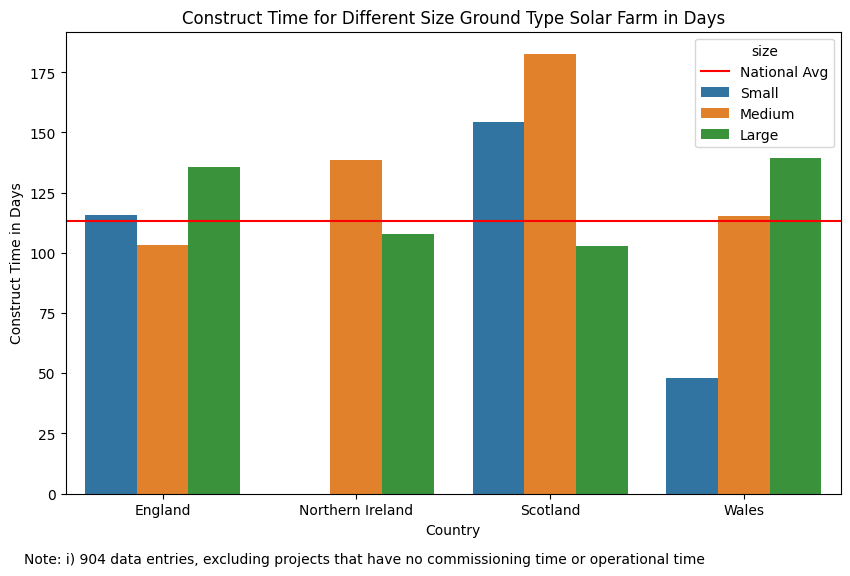

In [28]:
plt.figure(figsize=(10,6))
sns.barplot(data=df_solar_construct, x='country', y='construct_time', hue='size', errorbar=None)
plt.axhline(y=df_solar_construct['construct_time'].mean(), label='National Avg', color="red")
plt.xlabel('Country')
plt.ylabel('Construct Time in Days')
plt.title('Construct Time for Different Size Ground Type Solar Farm in Days')
plt.annotate("Note:" + " i) " + str(len(df_solar_construct)) + " data entries, excluding projects that have no commissioning time or operational time ", 
             (0, 0), xycoords='data', textcoords='offset points', 
             xytext=(-100, -50), ha='left')
plt.legend(title='size')
plt.show()

# **<u>Conclusion - Grounded Type Solar<u>**

* England has the highest number of submissions, primarily due to its geographical advantageous - sunlight availability. Its southern location results in an increased number of sunlight hours compared to other countries, making it an ideal location for solar projects. Additionally, the application processing time in England is notably shorter than in other countries. In contrast, all other countries have accumulated fewer than 200 submissions per size category.<br>
<br>
* There is a remarkable approval rate, indicating strong support for solar projects. This high approval rate suggests that people in England are generally receptive to and supportive of solar initiatives.<br>
<br>
* The average construction time for solar farms in England consistently falls within the range of 100 to 125 days, demonstrating consistency in project timelines.

## Things to be improved
* Further breakdown the analysis into regions for a more comprehensive evaluation.
* Refine the process length calculation methodology by factoring in the appeals process

# **<u>Final Word<u>**

* This portfolio marks my very first data analyst project. The decision to create one stemmed from my accomplishment of both the Google Data Analytics Professional Certificate and the Advanced Google Data Analytics Professional Certificate. [credly](https://www.credly.com/users/yong-sheng-wong/badges) <br>

* I welcome and greatly appreciate any feedback or comments on this portfolio. Feel free to reach out to me via my [Email](bennywong915@gmail.com) or [linkedin](https://www.linkedin.com/in/yong-sheng-wong/). Your insights are invaluable to me.

